### Labrador Embeddings

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

from src.preprocessing import preprocess_df, TextEncoder
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer
from src.dataset import LabradorDataset

from src.train import train_labrador
from src.test import test_model

### Constants

In [2]:
# Dataset:
FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

# Device:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

# Data loader: 
test_size = 0.2
batch_size = 512
num_workers = 4
max_len = 8
MASKING = 0.40

# Model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 4 #12
num_blocks = 10 #12
transformer_feedforward_dim = 1024 #3072
dropout_rate = 0.3
continuous_head_activation = 'relu'

# Training:
optimizer = 'Adam'
num_epochs = 12
save_model = True
model_path = 'labrador_model.pth'
categorical_loss_weight = 1.0
continuous_loss_weight = 1.0
lr = 8e-6


### Read dataset

In [3]:
df = pd.read_csv(FILE)
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [4]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS)

### Generate Sequences

In [5]:
# Generate the sequences:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [6]:
mrl.head(3)

itemid,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,Wbc,nstr,lab_ids,lab_values
0,10000032,22595853.0,2180-05-07,0.530612,0.007895,0.258621,0.609524,0.088028,0.585253,0.027731,0.004782,Bic 0.5306122448979591 Crt 0.00789473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.5306122448979591, 0.007894736842105262, 0.2..."
1,10000032,22841357.0,2180-06-27,0.469388,0.007895,0.318966,0.504762,0.102113,0.571429,0.055462,0.007515,Bic 0.46938775510204084 Crt 0.0078947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.007894736842105262, 0...."
2,10000032,25742920.0,2180-08-06,0.489796,0.015789,0.413793,0.504762,0.130282,0.557604,0.053782,0.008539,Bic 0.48979591836734687 Crt 0.0157894736842105...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.48979591836734687, 0.015789473684210523, 0...."


In [7]:
# See the largest element in: 
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019.0,[Bic 0.4489795918367347 Crt 0.0289473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.02894736842105263, 0.17..."
1,20000024.0,[Bic 0.46938775510204084 Crt 0.028947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.02894736842105263, 0.3..."
2,20000034.0,[Bic 0.4489795918367347 Crt 0.0605263157894736...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.06052631578947368, 0.28..."


#### Train and Test Split

In [8]:
lab_ids = grouped_mrl.lab_ids.values
lab_values = grouped_mrl.lab_values.values

lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(lab_ids, lab_values, test_size=test_size, random_state=42)

#### Tokenize

In [9]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)

In [10]:
# Example of how to use the tokenizer:
tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=10)

{'input_ids': array([[ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10]]),
 'continuous': array([[6.73469388e-01, 7.89473684e-02, 1.46551724e-01, 6.09523810e-01,
         3.80281690e-01, 6.31336406e-01, 4.15966387e-02, 6.94523511e-03,
         1.00000000e+01, 1.00000000e+01],
        [6.12244898e-01, 2.89473684e-02, 1.37931034e-01, 7.04761905e-01,
         9.85915493e-02, 3.50230415e-01, 7.85714286e-02, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [5.30612245e-01, 2.10526316e-02, 2.06896552e-01, 6.28571429e-01,
         5.63380282e-02, 4.42396313e-01, 1.18067227e-01, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [4.48979592e-01, 1.84210526e-02, 2.32758621e-01, 6.28571429e-01,
         3.16901408e-02, 6.77419355e-01, 1.07983193e-01, 1.04747808e-02,
         1.

### Dataloader

In [11]:
dataset_train = LabradorDataset(continuous=lab_values_train, categorical=lab_ids_train, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)

# Dataloader:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Wbc': 1, 'Hgb': 2, 'Plt': 3, 'Ure': 4, 'Sod': 5, 'Pot': 6, 'Bic': 7}
{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Wbc': 1, 'Hgb': 2, 'Plt': 3, 'Ure': 4, 'Sod': 5, 'Pot': 6, 'Bic': 7}


### Model

In [12]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

In [13]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation=continuous_head_activation, dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-9): 10 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dr

### Train the model

In [14]:
# Loss functions
categorical_loss_fn = nn.CrossEntropyLoss()
continuous_loss_fn = nn.MSELoss()

100%|██████████| 104/104 [00:06<00:00, 16.97it/s]


Epoch 1/12, Training Loss: 2.2413588736368264, Validation Loss: 1.9858163801523356


100%|██████████| 104/104 [00:06<00:00, 16.87it/s]


Epoch 2/12, Training Loss: 1.9672557993787498, Validation Loss: 1.9439135159437473


100%|██████████| 104/104 [00:06<00:00, 16.87it/s]


Epoch 3/12, Training Loss: 1.940094983232194, Validation Loss: 1.926604790183214


100%|██████████| 104/104 [00:06<00:00, 17.02it/s]


Epoch 4/12, Training Loss: 1.932235980667354, Validation Loss: 1.934294195129321


100%|██████████| 104/104 [00:06<00:00, 16.88it/s]


Epoch 5/12, Training Loss: 1.9290834495410827, Validation Loss: 1.9242398887872696


100%|██████████| 104/104 [00:06<00:00, 17.02it/s]


Epoch 6/12, Training Loss: 1.9249660637643602, Validation Loss: 1.919661739697823


100%|██████████| 104/104 [00:06<00:00, 16.86it/s]


Epoch 7/12, Training Loss: 1.9218617395502358, Validation Loss: 1.9246218777619875


100%|██████████| 104/104 [00:06<00:00, 16.92it/s]


Epoch 8/12, Training Loss: 1.9230684327042622, Validation Loss: 1.9177280091322386


100%|██████████| 104/104 [00:06<00:00, 16.98it/s]


Epoch 9/12, Training Loss: 1.920074728951938, Validation Loss: 1.915937262085768


100%|██████████| 104/104 [00:06<00:00, 16.81it/s]


Epoch 10/12, Training Loss: 1.920303461632291, Validation Loss: 1.9146514534950256


100%|██████████| 104/104 [00:06<00:00, 16.94it/s]


Epoch 11/12, Training Loss: 1.91868687885395, Validation Loss: 1.9168558487525353


100%|██████████| 104/104 [00:06<00:00, 16.85it/s]


Epoch 12/12, Training Loss: 1.9190885214413997, Validation Loss: 1.9156311119978244


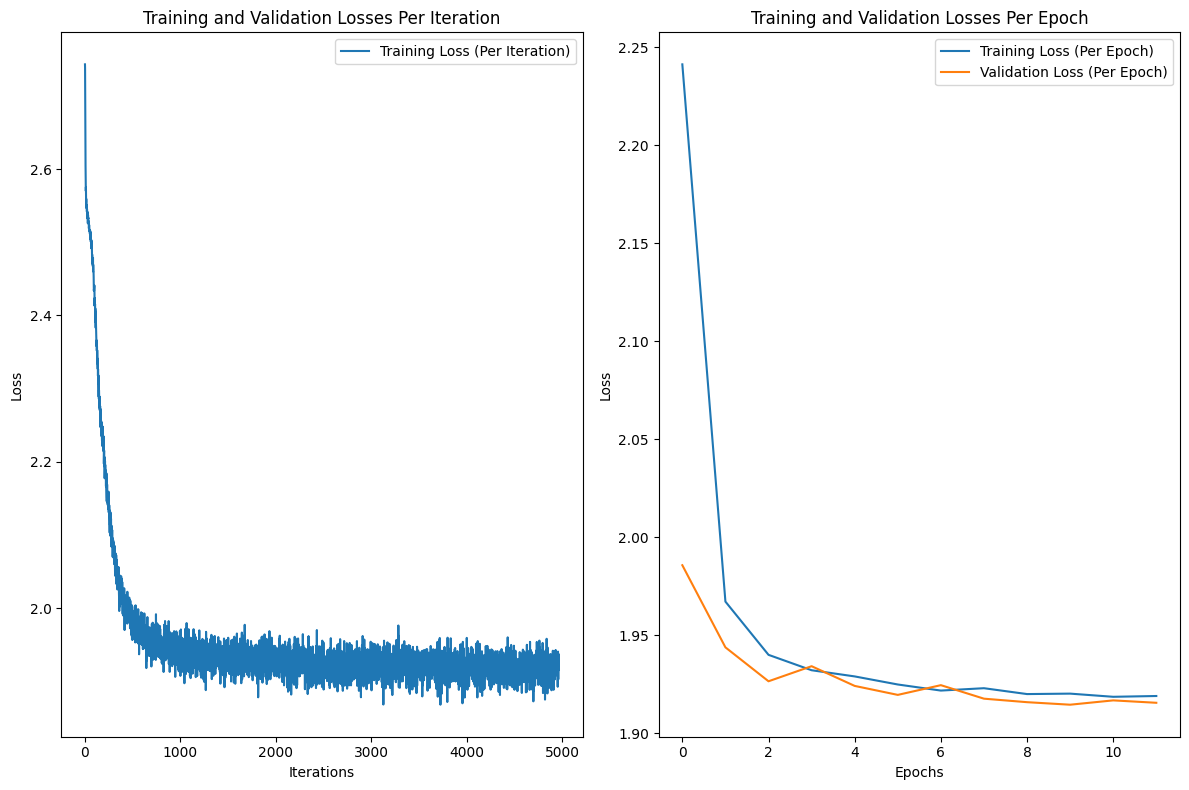

In [15]:
# Train and validate the model
trained_model = train_labrador(model, train_loader, test_loader, categorical_loss_fn, continuous_loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=device, save_model=save_model, model_path=model_path, categorical_loss_weight=categorical_loss_weight, continuous_loss_weight=continuous_loss_weight, lr=lr)

In [ ]:
# Save tokenizer
tokenizer.save_pretrained('labrador_tokenizer/')

### Test the model

In [16]:
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=0)
# Dataloader:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Wbc': 1, 'Hgb': 2, 'Plt': 3, 'Ure': 4, 'Sod': 5, 'Pot': 6, 'Bic': 7}


In [21]:
test_model(trained_model, test_loader, device, COLUMNS)

100%|██████████| 104/104 [00:05<00:00, 17.37it/s]


{'Bic': {'rmse': [0.086016738195594],
  'mae': [0.06613384850597469],
  'r2': [-0.20131242006529027]},
 'Crt': {'rmse': [0.042110525297904704],
  'mae': [0.020773371241305585],
  'r2': [-0.08753747856980088]},
 'Pot': {'rmse': [0.04585034396300611],
  'mae': [0.034253659384675235],
  'r2': [0.012102459024660561]},
 'Sod': {'rmse': [0.06622855158581785],
  'mae': [0.05665971828306621],
  'r2': [-2.086504283292569]},
 'Ure': {'rmse': [0.0637500391866958],
  'mae': [0.03618826496614874],
  'r2': [-0.06523546560134696]},
 'Hgb': {'rmse': [0.09948469824450878],
  'mae': [0.08100428777511412],
  'r2': [-0.10704083890135707]},
 'Plt': {'rmse': [0.049975810210515205],
  'mae': [0.03447125158892357],
  'r2': [-0.1474695135895432]},
 'Wbc': {'rmse': [0.012445089987730659],
  'mae': [0.00985360168744061],
  'r2': [-1.6802015094659697]}}

##### Push to HuggingFace (Optional)

In [26]:
from huggingface_hub import notebook_login
from huggingface_hub import upload_file
from huggingface_hub import HfApi, HfFolder

notebook_login()

api = HfApi()

model_path = "labrador_model.pth"
tokenizer_config_path = "labrador_tokenizer/tokenizer_config.json"

repo_id = "dsrestrepo/Labrador_pt"
repo_url = f"https://huggingface.co/{repo_id}"

# Upload the model
upload_file(path_or_fileobj=model_path, path_in_repo="labrador_model.pth", repo_id=repo_id, token=HfFolder.get_token())

# Upload the tokenizer configuration
upload_file(path_or_fileobj=tokenizer_config_path, path_in_repo="tokenizer_config.json", repo_id=repo_id, token=HfFolder.get_token())


labrador_model.pth:   0%|          | 0.00/165M [00:00<?, ?B/s]

'https://huggingface.co/dsrestrepo/Labrador_pt/blob/main/tokenizer_config.json'